# Jane Street Market Prediction - TPU Training

To run this notebook on kaggle, open the interactive editor and select to `Google Cloud SDK` from the `Addons` dropdown menu. Follow the instructions to link a Google Cloud account. Then select `TPU v3-8` as the accelerator in the `Settings` pane on the right before running the notebook.

Run some setup code.

In [1]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, PrecisionAtRecall
from tensorflow.keras.optimizers import SGD

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

# make the x,y labels legible on plots
plt.rc("axes", labelsize=16)

# set up the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
tpu_replicas = tpu_strategy.num_replicas_in_sync

# get dataset credential from the Google Cloud SDK
# and  pass credential to tensorflow
# this needs to run after TPU intialization
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

# set tensorflow's random seed
tf.random.set_seed(13)

Settings.

In [2]:
# training parameters
EPOCHS = 200
BATCH_SIZE = 32 * tpu_replicas
LEARNING_RATE = 0.01
MIN_RECALL = 0.55
LABEL_SMOOTHING = 0

# cross-validation parameters
FOLDS = 5
HOLDOUT = 4

# model parameters
WINDOW_SIZE = 40
NOISE = 0.05

# write relevant parameters to params.json for other notebooks
params = {"holdout": HOLDOUT, "window_size": WINDOW_SIZE}
with open(os.path.join(os.curdir, "params.json"), "w") as file:
    json.dump(params, file)

`get_dataset()` returns a dataset generated from the folds in the list `folds`.

In [3]:
def get_dataset(folds, repeat=False, shuffle=False, cache=False):
    # load a dictionary mapping feature names to columns
    col_file = os.path.join(os.pardir, "input",
                            "jane-street-market-prediction-data",
                            "columns.json")
    with open(col_file) as file:
        cols = json.loads(file.read())

    # shorthand notation for autotune option
    auto = tf.data.experimental.AUTOTUNE

    # opens a tf record in filename as a dataset that parses serialized
    # tensors and returns sliding windows of WINDOW_SIZE samples
    def open_windowed_ds(filename):
        ds = tf.data.TFRecordDataset(filename)
        ds = ds.map(lambda x: tf.io.parse_tensor(x, tf.float32), num_parallel_calls=auto)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda x: x.batch(WINDOW_SIZE))
        return ds

    # create a dataset with filenames of tf records in files_ds
    # then interleave the datasets obtained by calling
    # open_windowed_ds(x) on each element of files_ds
    data_path = KaggleDatasets().get_gcs_path()
    patterns = [data_path + f"/fold{fold}" + "/*.tfrec" for fold in folds]
    files = tf.io.gfile.glob(patterns)
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    ds = files_ds.interleave(open_windowed_ds, num_parallel_calls=auto)

    # filter out any time series spanning multiple dates
    def single_date(series):
        dates, ix = tf.unique(series[:, cols["date"]])
        return tf.equal(tf.size(dates), tf.constant(1))

    ds = ds.filter(single_date)

    # separate the series into a training sample consisting
    # of the features and a label indicating whether the
    # response at final time is positive
    # need to explicitly reshape the tensors here for things
    # to work properly on TPU
    def collate(series):
        X = series[:, cols["feature_0"]:(cols["feature_129"] + 1)]
        y = (1.0 + tf.sign(series[-1, cols["resp"]])) / 2.0
        return tf.reshape(X, [WINDOW_SIZE, 130]), tf.reshape(y, [1])

    ds = ds.map(collate, num_parallel_calls=auto)

    # if shuffling, allow the dataset to ignore the order for speed
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = not shuffle
    ds = ds.with_options(ignore_order)

    # check if the dataset should repeat once exhausted
    ds = ds.repeat() if repeat else ds
    
    # check if we should shuffle the dataset
    ds = ds.shuffle(4 * BATCH_SIZE) if shuffle else ds

    # set the batch size of the dataset
    ds = ds.batch(BATCH_SIZE)
    
    # check if we should cache the dataset
    ds = ds.cache() if cache else ds

    # prefetch new batches in the background
    ds = ds.prefetch(auto)

    return ds


# load a simpler non-windowed version of training set
# to adapt the normalization layer - see comments in
# get_dataset() for explanations
def get_norm_dataset(folds):
    col_file = os.path.join(os.pardir, "input",
                            "jane-street-market-prediction-data",
                            "columns.json")

    with open(col_file) as file:
        cols = json.loads(file.read())

    def parse(serialized):
        tensor = tf.io.parse_tensor(serialized, tf.float32)
        X = tensor[cols["feature_0"]:(cols["feature_129"] + 1)]
        return tf.reshape(X, [130])

    auto = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    data_path = KaggleDatasets().get_gcs_path()
    patterns = [data_path + f"/fold{fold}" + "/*.tfrec" for fold in folds]
    ds = tf.data.TFRecordDataset(tf.io.gfile.glob(patterns), num_parallel_reads=auto)
    
    ds = ds.with_options(ignore_order)
    ds = ds.map(parse, num_parallel_calls=auto)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(auto)
    
    return ds

Define the model.

In [4]:
train_folds = [fold for fold in range(FOLDS) if fold != HOLDOUT]

# compile model on the TPU
with tpu_strategy.scope():
    # binary cross-entropy as loss function, SGD as optimizer,
    # track precision at recall and area under the ROC curve
    loss = BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
    optimizer = SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)
    metrics = [PrecisionAtRecall(recall=MIN_RECALL, name="p@r"), AUC(name="auc")]

    
    # input layer
    inputs = layers.Input(shape=[WINDOW_SIZE, 130])
    
    # normalization layer
    norm = layers.experimental.preprocessing.Normalization()
    norm_ds = get_norm_dataset(train_folds)
    norm.adapt(norm_ds)
    flow = norm(inputs)
    
    # gaussian noise
    flow = layers.GaussianNoise(stddev=NOISE)(flow)
    flow = layers.BatchNormalization()(flow)
    
    # resnet
    last_filters = 130
    for filters, pool in zip(8 * [256], 8 * [False]):
        # skip connection
        skip = flow
        
        # make sure the skip connection has correct number of feature maps
        if filters != last_filters:
            skip = layers.Conv1D(filters=filters,
                                 kernel_size=1,
                                 activation=None,
                                 padding="same",
                                 data_format="channels_last")(skip)

        # convolutional block
        flow = layers.Conv1D(filters=filters,
                             kernel_size=3,
                             activation=None,
                             padding="same",
                             data_format="channels_last")(flow)
        flow = layers.BatchNormalization()(flow)
        flow = layers.Activation(keras.activations.swish)(flow)
        
        # dropout entire feature maps
        flow = layers.SpatialDropout1D(rate=0.2)(flow)
        
        flow = layers.Conv1D(filters=filters,
                             kernel_size=3,
                             activation=None,
                             padding="same",
                             data_format="channels_last")(flow)

        # merge flow and skip
        flow = layers.Add()([skip, flow])
        flow = layers.BatchNormalization()(flow)
        flow = layers.Activation(keras.activations.swish)(flow)
        
        # dropout entire feature maps
        flow = layers.SpatialDropout1D(rate=0.2)(flow)
        
        # pooling
        if pool:
            flow = layers.MaxPooling1D(pool_size=2, data_format="channels_last")(flow)
        
        last_filters = filters
    
    # flattened layers and dense logic for prediction
    flow = layers.Flatten()(flow)    
    flow = layers.Dense(units=1)(flow)
    outputs = layers.Activation("sigmoid")(flow)

    # compile the model and print a summary
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 130)]    0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 40, 130)      261         input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 40, 130)      0           normalization[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 130)      520         gaussian_noise[0][0]             
______________________________________________________________________________________________

Train the model.

In [5]:
# load stats dictionary to get the number of training samples
stats_file = os.path.join(os.pardir, "input",
                          "jane-street-market-prediction-data",
                          "stats.json")

with open(stats_file) as file:
    stats = json.loads(file.read())

samples = stats[str(HOLDOUT)]["length"]


# define callbacks for learning rate schedule and early stopping
stopping = EarlyStopping(monitor="val_auc",
                         mode="max",
                         patience=20,
                         min_delta=1e-3,
                         restore_best_weights=True)

rate = ReduceLROnPlateau(monitor="val_loss",
                         mode="min",
                         factor=0.5,
                         patience=10,
                         min_lr=1e-3,
                         min_delta=1e-3)

callbacks = [rate, stopping]


# get training and validation datasets and fit the model
train_ds = get_dataset(train_folds, repeat=True, shuffle=True)
valid_ds = get_dataset([HOLDOUT], cache=True)
hist = model.fit(train_ds,
                 epochs=EPOCHS,
                 steps_per_epoch=samples // BATCH_SIZE,
                 validation_data=valid_ds,
                 callbacks=callbacks)

Epoch 1/200
7337/7337 [==============================] - 196s 27ms/step - loss: 0.7330 - auc: 0.5033 - p@r: 0.5086 - val_loss: 0.7732 - val_auc: 0.4997 - val_p@r: 0.4968 - lr: 0.0100
Epoch 2/200
7337/7337 [==============================] - 185s 25ms/step - loss: 0.6944 - auc: 0.5046 - p@r: 0.5090 - val_loss: 0.7363 - val_auc: 0.5001 - val_p@r: 0.4969 - lr: 0.0100
Epoch 3/200
7337/7337 [==============================] - 186s 25ms/step - loss: 0.6934 - auc: 0.5060 - p@r: 0.5096 - val_loss: 0.6960 - val_auc: 0.5009 - val_p@r: 0.4970 - lr: 0.0100
Epoch 4/200
7337/7337 [==============================] - 189s 26ms/step - loss: 0.6933 - auc: 0.5070 - p@r: 0.5099 - val_loss: 0.6932 - val_auc: 0.5019 - val_p@r: 0.4980 - lr: 0.0100
Epoch 5/200
7337/7337 [==============================] - 188s 26ms/step - loss: 0.6931 - auc: 0.5088 - p@r: 0.5123 - val_loss: 0.6932 - val_auc: 0.5023 - val_p@r: 0.5002 - lr: 0.0100
Epoch 6/200
7337/7337 [==============================] - 188s 26ms/step - loss: 0.693

Plot the learning curve and associated metrics.

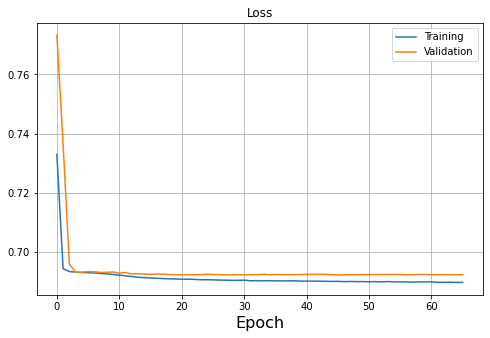

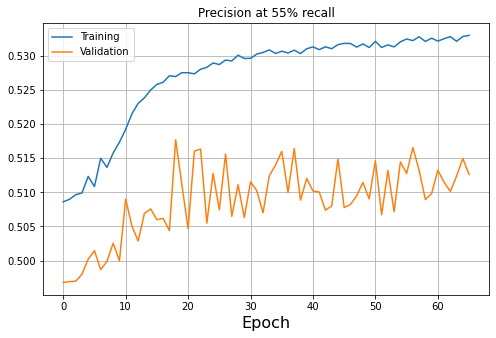

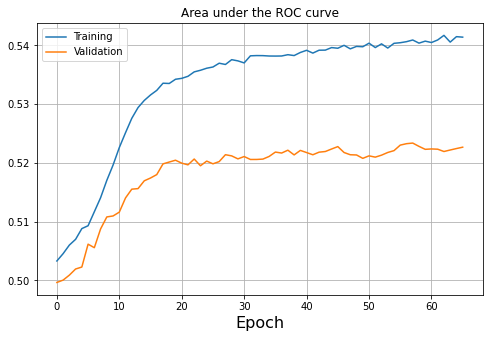

In [6]:
hist_df = pd.DataFrame(hist.history)

# loss
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["loss"], label="Training")
sns.lineplot(data=hist_df["val_loss"], label="Validation")
#sns.lineplot(data=hist_df["lr"], label="Learning rate")
plt.title("Loss")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# precision at recall
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["p@r"], label="Training")
sns.lineplot(data=hist_df["val_p@r"], label="Validation")
plt.title(f"Precision at {int(100 * MIN_RECALL)}% recall")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# area under ROC curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["auc"], label="Training")
sns.lineplot(data=hist_df["val_auc"], label="Validation")
plt.title("Area under the ROC curve")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

Plot ROC curve and precision vs. recall on validation set.

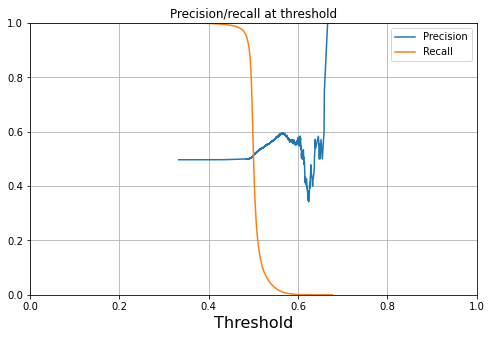

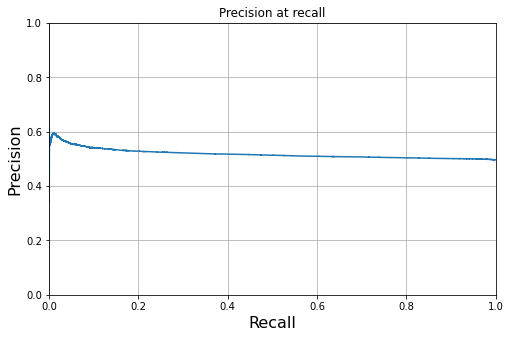

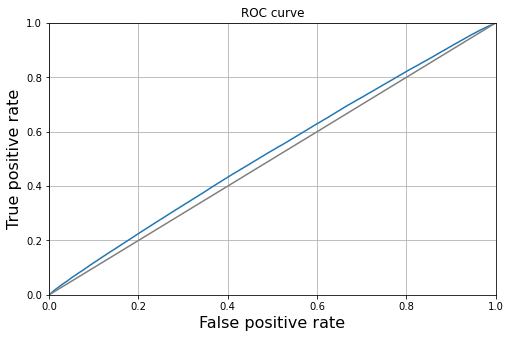

In [7]:
# store numpy arrays of labels in validation data
# and the probabilities predicted by the model
test_ds = get_dataset([HOLDOUT])

y_ds = test_ds.map(lambda X, y: y)
labels = np.vstack(list(y_ds.as_numpy_iterator()))

X_ds = test_ds.map(lambda X, y: X)
probs = model.predict(X_ds)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(labels, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(labels, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

Save the model architecture and weights.

In [8]:
with open("model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("model.h5")